In [1]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [2]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
# model.cuda()
model.cpu()
model.eval()
classes = utils.load_classes(class_path)
# Tensor = torch.cuda.FloatTensor
Tensor = torch.FloatTensor

/Users/wangning/Desktop/MyPython/vep3/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [3]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

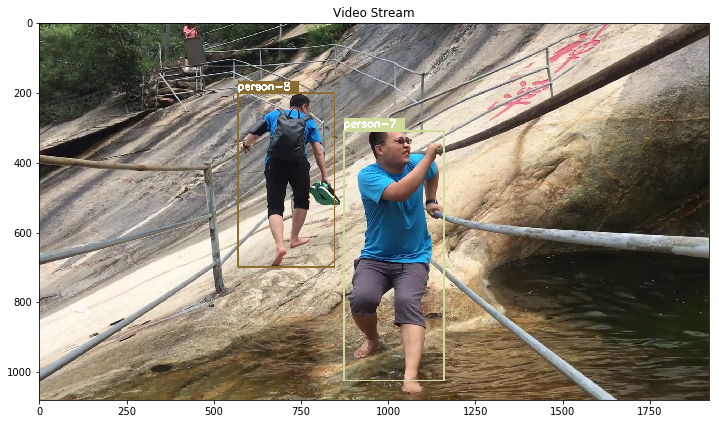

In [7]:
videopath = 'video/IMG_4129.mp4'

%pylab inline 
import cv2
from IPython.display import clear_output

cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
mot_tracker = Sort() 

#while(True):
for ii in range(40):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        tracked_objects = mot_tracker.update(detections.cpu())

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    clear_output(wait=True)